# **1. Multilayer Perceptron**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.8215805130000007
GPU (s):
0.047771494999992115
GPU speedup over CPU: 79x


## 1.1. Multilayer Perceptron 

To Predict International Airline Passengers (t+1, given t)

96 48
Epoch 1/200
47/47 - 1s - loss: 1299.3455 - 564ms/epoch - 12ms/step
Epoch 2/200
47/47 - 0s - loss: 579.8730 - 96ms/epoch - 2ms/step
Epoch 3/200
47/47 - 0s - loss: 546.1736 - 84ms/epoch - 2ms/step
Epoch 4/200
47/47 - 0s - loss: 543.9779 - 102ms/epoch - 2ms/step
Epoch 5/200
47/47 - 0s - loss: 548.5775 - 90ms/epoch - 2ms/step
Epoch 6/200
47/47 - 0s - loss: 540.7312 - 85ms/epoch - 2ms/step
Epoch 7/200
47/47 - 0s - loss: 544.0031 - 86ms/epoch - 2ms/step
Epoch 8/200
47/47 - 0s - loss: 546.0165 - 94ms/epoch - 2ms/step
Epoch 9/200
47/47 - 0s - loss: 545.4769 - 90ms/epoch - 2ms/step
Epoch 10/200
47/47 - 0s - loss: 546.1085 - 86ms/epoch - 2ms/step
Epoch 11/200
47/47 - 0s - loss: 540.4286 - 88ms/epoch - 2ms/step
Epoch 12/200
47/47 - 0s - loss: 551.2311 - 87ms/epoch - 2ms/step
Epoch 13/200
47/47 - 0s - loss: 549.2393 - 96ms/epoch - 2ms/step
Epoch 14/200
47/47 - 0s - loss: 541.8066 - 87ms/epoch - 2ms/step
Epoch 15/200
47/47 - 0s - loss: 543.9283 - 90ms/epoch - 2ms/step
Epoch 16/200
47/47 - 0s 

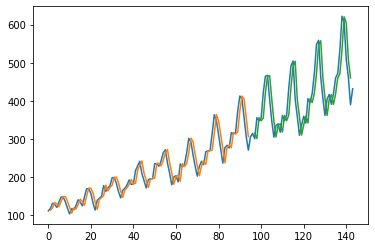

In [8]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t)
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
import tensorflow

# fix random seed for reproducibility
numpy.random.seed(42)
tensorflow.random.set_seed(42)

# load the dataset
dataframe = pd.read_csv('/content/drive/MyDrive/Dataset/international-airline-passengers.csv', usecols=[1],
    engine= 'python' , skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype( 'float32' )

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation= 'relu' ))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error' , optimizer= 'adam' )
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print( 'Train Score: %.2f MSE (%.2f RMSE)'  % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print( 'Test Score: %.2f MSE (%.2f RMSE) ' % (testScore, math.sqrt(testScore)))

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 1.2.Multilayer Perceptron Using the Window Method

96 48
Epoch 1/200
43/43 - 0s - loss: 33927.6055
Epoch 2/200
43/43 - 0s - loss: 4491.6704
Epoch 3/200
43/43 - 0s - loss: 1880.2795
Epoch 4/200
43/43 - 0s - loss: 1597.3038
Epoch 5/200
43/43 - 0s - loss: 1452.8530
Epoch 6/200
43/43 - 0s - loss: 1374.7267
Epoch 7/200
43/43 - 0s - loss: 1332.1117
Epoch 8/200
43/43 - 0s - loss: 1228.4628
Epoch 9/200
43/43 - 0s - loss: 1142.7552
Epoch 10/200
43/43 - 0s - loss: 1087.7656
Epoch 11/200
43/43 - 0s - loss: 1094.1051
Epoch 12/200
43/43 - 0s - loss: 1052.6210
Epoch 13/200
43/43 - 0s - loss: 1018.6019
Epoch 14/200
43/43 - 0s - loss: 1060.3807
Epoch 15/200
43/43 - 0s - loss: 988.6117
Epoch 16/200
43/43 - 0s - loss: 1091.0707
Epoch 17/200
43/43 - 0s - loss: 995.6116
Epoch 18/200
43/43 - 0s - loss: 921.3056
Epoch 19/200
43/43 - 0s - loss: 930.7065
Epoch 20/200
43/43 - 0s - loss: 932.4339
Epoch 21/200
43/43 - 0s - loss: 890.1104
Epoch 22/200
43/43 - 0s - loss: 891.5375
Epoch 23/200
43/43 - 0s - loss: 843.5439
Epoch 24/200
43/43 - 0s - loss: 813.1270
Epo

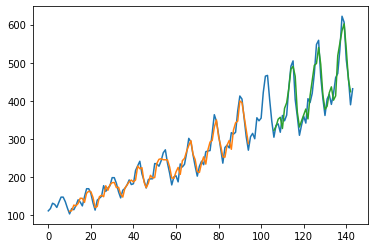

In [ ]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t, t-1, t-2)
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
import tensorflow
# fix random seed for reproducibility
numpy.random.seed(42)
tensorflow.random.set_seed(42)
# load the dataset
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/international-airline-passengers.csv', usecols=[1],
    engine= 'python' , skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype( 'float32' )

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# reshape dataset
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation= 'relu' ))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error' , optimizer= 'adam' )
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print( 'Train Score: %.2f MSE (%.2f RMSE)'  % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print( 'Test Score: %.2f MSE (%.2f RMSE) ' % (testScore, math.sqrt(testScore)))

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# **2. RNN**

## 2.1. LSTM Network For Regression

Epoch 1/100
94/94 - 2s - loss: 0.0433
Epoch 2/100
94/94 - 0s - loss: 0.0218
Epoch 3/100
94/94 - 0s - loss: 0.0166
Epoch 4/100
94/94 - 0s - loss: 0.0154
Epoch 5/100
94/94 - 0s - loss: 0.0145
Epoch 6/100
94/94 - 0s - loss: 0.0137
Epoch 7/100
94/94 - 0s - loss: 0.0129
Epoch 8/100
94/94 - 0s - loss: 0.0122
Epoch 9/100
94/94 - 0s - loss: 0.0114
Epoch 10/100
94/94 - 0s - loss: 0.0108
Epoch 11/100
94/94 - 0s - loss: 0.0100
Epoch 12/100
94/94 - 0s - loss: 0.0094
Epoch 13/100
94/94 - 0s - loss: 0.0085
Epoch 14/100
94/94 - 0s - loss: 0.0078
Epoch 15/100
94/94 - 0s - loss: 0.0071
Epoch 16/100
94/94 - 0s - loss: 0.0065
Epoch 17/100
94/94 - 0s - loss: 0.0059
Epoch 18/100
94/94 - 0s - loss: 0.0052
Epoch 19/100
94/94 - 0s - loss: 0.0046
Epoch 20/100
94/94 - 0s - loss: 0.0042
Epoch 21/100
94/94 - 0s - loss: 0.0037
Epoch 22/100
94/94 - 0s - loss: 0.0033
Epoch 23/100
94/94 - 0s - loss: 0.0030
Epoch 24/100
94/94 - 0s - loss: 0.0028
Epoch 25/100
94/94 - 0s - loss: 0.0026
Epoch 26/100
94/94 - 0s - loss: 0.

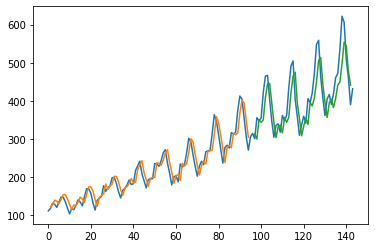

In [ ]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(42)
tensorflow.random.set_seed(42)
# load the dataset
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/international-airline-passengers.csv', usecols=[1],
    engine= 'python' , skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype( 'float32' )

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error' , optimizer= 'adam' )
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print( 'Train Score: %.2f RMSE'  % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print( 'Test Score: %.2f RMSE'  % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 2.2. LSTM For Regression Using the Window Method

Epoch 1/100
85/85 - 2s - loss: 0.0521
Epoch 2/100
85/85 - 0s - loss: 0.0141
Epoch 3/100
85/85 - 0s - loss: 0.0075
Epoch 4/100
85/85 - 0s - loss: 0.0063
Epoch 5/100
85/85 - 0s - loss: 0.0054
Epoch 6/100
85/85 - 0s - loss: 0.0048
Epoch 7/100
85/85 - 0s - loss: 0.0042
Epoch 8/100
85/85 - 0s - loss: 0.0039
Epoch 9/100
85/85 - 0s - loss: 0.0036
Epoch 10/100
85/85 - 0s - loss: 0.0034
Epoch 11/100
85/85 - 0s - loss: 0.0034
Epoch 12/100
85/85 - 0s - loss: 0.0032
Epoch 13/100
85/85 - 0s - loss: 0.0030
Epoch 14/100
85/85 - 0s - loss: 0.0031
Epoch 15/100
85/85 - 0s - loss: 0.0027
Epoch 16/100
85/85 - 0s - loss: 0.0028
Epoch 17/100
85/85 - 0s - loss: 0.0027
Epoch 18/100
85/85 - 0s - loss: 0.0026
Epoch 19/100
85/85 - 0s - loss: 0.0024
Epoch 20/100
85/85 - 0s - loss: 0.0024
Epoch 21/100
85/85 - 0s - loss: 0.0023
Epoch 22/100
85/85 - 0s - loss: 0.0022
Epoch 23/100
85/85 - 0s - loss: 0.0021
Epoch 24/100
85/85 - 0s - loss: 0.0021
Epoch 25/100
85/85 - 0s - loss: 0.0020
Epoch 26/100
85/85 - 0s - loss: 0.

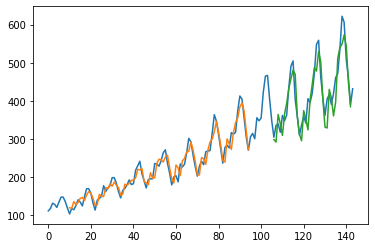

In [ ]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)



# fix random seed for reproducibility
numpy.random.seed(42)
tensorflow.random.set_seed(42)
# load the dataset
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/international-airline-passengers.csv', usecols=[1],
    engine= 'python' , skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype( 'float32' )

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]




# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error' , optimizer= 'adam' )
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)




# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print( 'Train Score: %.2f RMSE'  % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print( 'Test Score: %.2f RMSE'  % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 2.3. LSTM For Regression with Time Steps

Epoch 1/100
92/92 - 2s - loss: 0.0398
Epoch 2/100
92/92 - 0s - loss: 0.0155
Epoch 3/100
92/92 - 0s - loss: 0.0128
Epoch 4/100
92/92 - 0s - loss: 0.0113
Epoch 5/100
92/92 - 0s - loss: 0.0099
Epoch 6/100
92/92 - 0s - loss: 0.0091
Epoch 7/100
92/92 - 0s - loss: 0.0078
Epoch 8/100
92/92 - 0s - loss: 0.0069
Epoch 9/100
92/92 - 0s - loss: 0.0062
Epoch 10/100
92/92 - 0s - loss: 0.0056
Epoch 11/100
92/92 - 0s - loss: 0.0051
Epoch 12/100
92/92 - 0s - loss: 0.0047
Epoch 13/100
92/92 - 0s - loss: 0.0045
Epoch 14/100
92/92 - 0s - loss: 0.0044
Epoch 15/100
92/92 - 0s - loss: 0.0042
Epoch 16/100
92/92 - 0s - loss: 0.0042
Epoch 17/100
92/92 - 0s - loss: 0.0041
Epoch 18/100
92/92 - 0s - loss: 0.0041
Epoch 19/100
92/92 - 0s - loss: 0.0040
Epoch 20/100
92/92 - 0s - loss: 0.0041
Epoch 21/100
92/92 - 0s - loss: 0.0041
Epoch 22/100
92/92 - 0s - loss: 0.0041
Epoch 23/100
92/92 - 0s - loss: 0.0040
Epoch 24/100
92/92 - 0s - loss: 0.0039
Epoch 25/100
92/92 - 0s - loss: 0.0040
Epoch 26/100
92/92 - 0s - loss: 0.

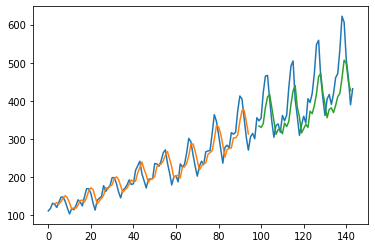

In [ ]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(42)
tensorflow.random.set_seed(42)

# load the dataset
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/international-airline-passengers.csv', usecols=[1],
    engine= 'python' , skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype( 'float32' )

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))



# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=1))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error' , optimizer= 'adam' )
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print( 'Train Score: %.2f RMSE'  % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print( 'Test Score: %.2f RMSE'  % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 2.4. LSTM With Memory Between Batches

92/92 - 2s - loss: 0.0049
92/92 - 0s - loss: 0.0112
92/92 - 0s - loss: 0.0062
92/92 - 0s - loss: 0.0052
92/92 - 0s - loss: 0.0048
92/92 - 1s - loss: 0.0047
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s -

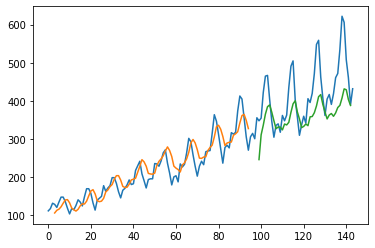

In [ ]:
# LSTM for international airline passengers problem with Memory Between Batches
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(42)
tensorflow.random.set_seed(42)

# load the dataset
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/international-airline-passengers.csv', usecols=[1],
    engine= 'python' , skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype( 'float32' )

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))



# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error' , optimizer= 'adam' )
for i in range(100):
  model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model.reset_states()

# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print( 'Train Score: %.2f RMSE'  % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print( 'Test Score: %.2f RMSE'  % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 2.5. Stacked LSTMs With Memory Between Batches

92/92 - 3s - loss: 0.0049
92/92 - 0s - loss: 0.0084
92/92 - 0s - loss: 0.0069
92/92 - 0s - loss: 0.0063
92/92 - 0s - loss: 0.0059
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0056
92/92 - 0s - loss: 0.0055
92/92 - 0s - loss: 0.0054
92/92 - 0s - loss: 0.0053
92/92 - 0s - loss: 0.0053
92/92 - 0s - loss: 0.0053
92/92 - 0s - loss: 0.0052
92/92 - 0s - loss: 0.0052
92/92 - 0s - loss: 0.0052
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0048
92/92 - 0s - loss: 0.0048
92/92 - 0s - loss: 0.0048
92/92 - 0s - loss: 0.0048
92/92 - 0s -

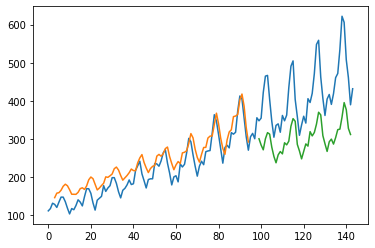

In [ ]:
#  Stacked LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(42)
tensorflow.random.set_seed(42)

# load the dataset
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/international-airline-passengers.csv', usecols=[1],
    engine= 'python' , skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype( 'float32' )

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))



# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True,
    return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error' , optimizer= 'adam')
for i in range(100):
  model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model.reset_states()

# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print( 'Train Score: %.2f RMSE'  % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print( 'Test Score: %.2f RMSE'  % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()